# Food Vision 101

#### Mount "Drive" for files loading.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Appends the path of Colab Notebooks, to be able to load files from external drive.

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

## Starting main content

In [3]:
# Installs tensorflow if there is not installed already.
!pip install tensorflow

In [4]:
# Ignores warnings if continuously showed up.
import warnings
warnings.filterwarnings(action = "once")

# Imports common libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random, itertools, os, datetime

from importlib import reload

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._boots

In [5]:
# Imports helper function script.
import extras.helper_functions as hf

### Checking if NVIDIA GPU exists in system and if it is enabled.

In [6]:
# !nvidia-smi -L

### Installs tensorflow_dataset and getting preferable dataset

In [7]:
# Getting access to tensorflow datasets
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

In [8]:
# Lists all available datsets
datasets_list = tfds.list_builders() # gets all available dataseys in TFDS
print("food101" in datasets_list) # checking if our dataset target is in the list of TDFS datasets.

True


In [9]:
# Loads the data.
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # data gets returned in tuple format (data, label)
                                             with_info = True)

## Exploring the Food101 data from Tensorflow Datasets

In [10]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
# Class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Takes sample of the train data.
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# Output info about our training sample.
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 81
  Class name (str form): ramen
  


In [14]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[242, 254, 252],
        [241, 253, 251],
        [240, 252, 250],
        ...,
        [241, 211, 101],
        [242, 212, 102],
        [245, 215, 105]],

       [[240, 252, 250],
        [240, 252, 250],
        [239, 251, 249],
        ...,
        [245, 215, 105],
        [242, 212, 102],
        [240, 210, 100]],

       [[238, 250, 248],
        [238, 250, 248],
        [238, 250, 248],
        ...,
        [250, 218, 107],
        [243, 211, 100],
        [238, 206,  95]],

       ...,

       [[ 82,  81,  77],
        [ 83,  82,  78],
        [ 82,  81,  77],
        ...,
        [126, 128, 127],
        [135, 137, 136],
        [139, 141, 140]],

       [[ 82,  79,  74],
        [ 82,  79,  74],
        [ 81,  78,  73],
        ...,
        [209, 209, 209],
        [217, 217, 217],
        [215, 215, 215]],

       [[ 78,  75,  70],
        [ 77,  74,  69],
        [ 76,  73,  68],
        ...,
        [187, 187, 18

In [15]:
# What are the min and max values of image tensor.
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

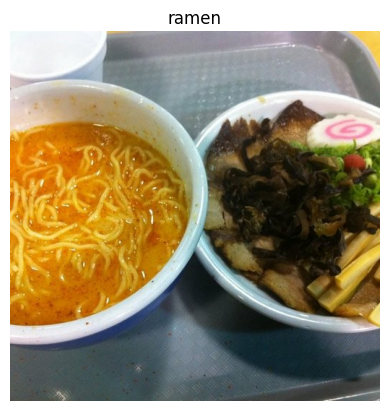

In [16]:
# Plot an image from Tensorflow Dataset
plt.imshow(image)
plt.title(class_names[label.numpy()]);
plt.axis(False);

## Creating preprocessing functions for our data

In [17]:
# Making a function for preprocessing images
def preprocess_img(image, label, img_shape = 224, scaling = False):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]

  Args:
    image: the selected image which will be casted.
    label (int): the id of image's class_name.
    img_shape (int): size of image
    scaling (bool): a variable for scaling of image's values (e.g. ResNet => True, EfficientNet => False).
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  if scaling == True:
    image = image / 255.
  return tf.cast(image, tf.float32), label # return(floata32_image, label) tuple

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[242 254 252]
  [241 253 251]
  [240 252 250]
  ...
  [241 211 101]
  [242 212 102]
  [245 215 105]]

 [[240 252 250]
  [240 252 250]
  [239 251 249]
  ...
  [245 215 105]
  [242 212 102]
  [240 210 100]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[240.4847  252.4847  250.4847 ]
  [238.42857 250.42857 248.42857]
  [238.29082 249.86224 248.07652]
  ...
  [251.4235  219.20923 107.78071]
  [246.3571  216.3571  106.3571 ]
  [241.92346 211.92346 101.92346]]

 [[237.07143 249.07143 247.07143]
  [238.      250.      248.     ]
  [240.14285 250.14285 249.14285]
  ...
  [248.22957 215.28569 101.85716]
  [250.99489 218.99489 106.27042]
  [243.07126 211.07126 100.07126]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

In [19]:
# Maps preprocessing function to train data (and parallelize).
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

In [20]:
# Shuffles train_data and turn it into batches and prefetches it (load it faster).
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
# Maps preprocessing function to test data (and parallelize).
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [23]:
# Creates tensorboard callback.
checkpoint_path = "/tmp/ckpt/checkpoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

## Setup mix precision training

In [24]:
# Turns on mixed precision training.
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # sets global data policy to mixed precision.

In [25]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [26]:
# Creates base model.
INPUT_SHAPE = (224, 224)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Creates functional model.
inputs = tf.keras.layers.Input(shape = INPUT_SHAPE + (3,), name = "input_shape")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

In [27]:
# Compiles model.
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_shape (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Checking layers dtype policies

In [29]:
for layer in model.layers:
    print(f"{layer.name} --- {layer.trainable} --- {layer.dtype} --- {layer.dtype_policy}")

input_shape --- True --- float32 --- <DTypePolicy "mixed_float16">
efficientnetb0 --- False --- float32 --- <DTypePolicy "mixed_float16">
global_average_pooling2d --- True --- float32 --- <DTypePolicy "mixed_float16">
dense --- True --- float32 --- <DTypePolicy "mixed_float16">
softmax_float32 --- True --- float32 --- <DTypePolicy "float32">


In [30]:
for layer in base_model.layers:
    print(f"{layer.name} --- {layer.trainable} --- {layer.dtype} --- {layer.dtype_policy}")

input_layer --- False --- float32 --- <DTypePolicy "mixed_float16">
rescaling --- False --- float32 --- <DTypePolicy "mixed_float16">
normalization --- False --- float32 --- <DTypePolicy "mixed_float16">
rescaling_1 --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_conv_pad --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_conv --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_bn --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_activation --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_dwconv --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_bn --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_activation --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_squeeze --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_reshape --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_reduce --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_expand -

In [31]:
# Turns off all warnings except for errors.
tf.get_logger().setLevel('ERROR')

INITIAL_EPOCHS = 3

# Fits the model.
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs = 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks = [hf.create_tensorboard_callback("training_logs",
                                                                                                 "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250424-085219
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 219s 75ms/step - accuracy: 0.4748 - loss: 2.2929 - val_accuracy: 0.6923 - val_loss: 1.1397
Epoch 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 219s 67ms/step - accuracy: 0.6678 - loss: 1.2832 - val_accuracy: 0.7119 - val_loss: 1.0470
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 213s 71ms/step - accuracy: 0.7023 - loss: 1.1357 - val_accuracy: 0.7301 - val_loss: 0.9891


In [32]:
# Evaluates model on whole test data.
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.7276 - loss: 1.0003


[0.9958401918411255, 0.7306138873100281]

In [33]:
# Unfreezes all layers of base model.
base_model.trainable = True

# Refreezes all layers of base model, except the last 5.
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [34]:
# Checking the actual trainable layers after changes at base_model.
for layer in base_model.layers:
    print(f"{layer.name} --- {layer.trainable} --- {layer.dtype} --- {layer.dtype_policy}")

input_layer --- False --- float32 --- <DTypePolicy "mixed_float16">
rescaling --- False --- float32 --- <DTypePolicy "mixed_float16">
normalization --- False --- float32 --- <DTypePolicy "mixed_float16">
rescaling_1 --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_conv_pad --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_conv --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_bn --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_activation --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_dwconv --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_bn --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_activation --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_squeeze --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_reshape --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_reduce --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_expand -

In [35]:
# Recompiles the whole model (always recompile after any adjustments to a model).
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # LR is 10x lower than before for fine-tuning.
              metrics = ["accuracy"])

In [36]:
# Fine-tunes for 7 more epochs.
fine_tune_epochs = 10 # model has already done 3 epochs, this is the total number of epochs we're after (3 + 5 = 10).

history_101_food_classes_fine_tune = model.fit(train_data,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.15 * len(test_data)), # validates on 15% of the test data.
                                               initial_epoch = history_101_food_classes_feature_extract.epoch[-1], # starts from previous last epoch.
                                               callbacks = [hf.create_tensorboard_callback("training_logs",
                                                                                          "efficientnetb0_101_classes_all_data_fine_tune"),
                                                            model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20250424-090406
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 211s 77ms/step - accuracy: 0.7216 - loss: 1.0735 - val_accuracy: 0.7516 - val_loss: 0.9012
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 196s 80ms/step - accuracy: 0.7594 - loss: 0.9092 - val_accuracy: 0.7577 - val_loss: 0.8737
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 85ms/step - accuracy: 0.7824 - loss: 0.8207 - val_accuracy: 0.7635 - val_loss: 0.8542
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.7999 - loss: 0.7538 - val_accuracy: 0.7638 - val_loss: 0.8355
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.8160 - loss: 0.6998 - val_accuracy: 0.7701 - val_loss: 0.8194
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 161s 67ms/step - accuracy: 0.8303 - loss: 0.6501 - val_accuracy: 0.7654 - val_loss: 0.8282
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 67ms/step - accuracy: 0.8433 - loss: 0.6064 - 

In [37]:
# Evaluates fine-tuned model on the whole test dataset.
history_101_food_classes_fine_tune_results = model.evaluate(test_data)
history_101_food_classes_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.7718 - loss: 0.8181


[0.8152236938476562, 0.7743366360664368]

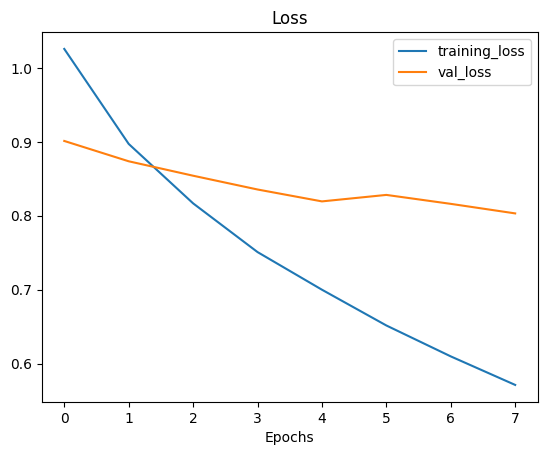

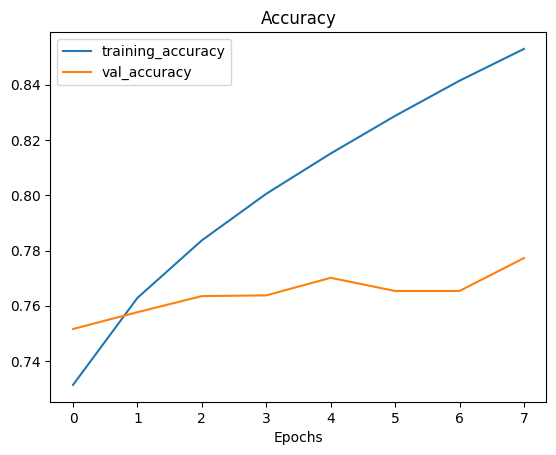

In [38]:
hf.plot_loss_curves(history_101_food_classes_fine_tune)

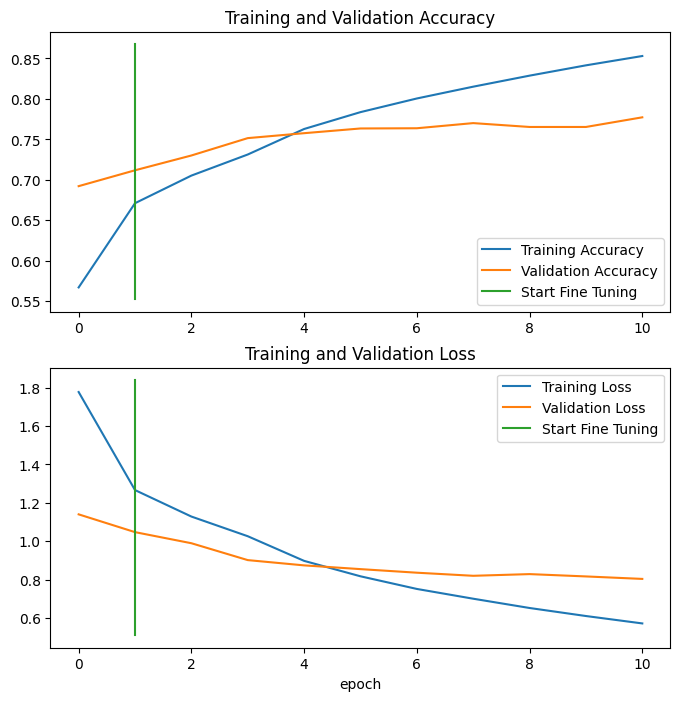

In [39]:
hf.compare_histories(history_101_food_classes_feature_extract, history_101_food_classes_fine_tune, history_101_food_classes_feature_extract.epoch[-1])

In [40]:
# Setting up EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 2)

# Creates ModelCheckpoint callback to save best model during fine-tuning.
checkpoint_path = "/tmp/ckpt/fine_tune/checkpoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = "val_loss")

In [41]:
# Creating learning rate reduction callback.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2, # multiplies the learning rate by 0.2 (reduce by 5x).
                                                 patience = 2,
                                                 verbose = 1, # prints out when learning rate goes down.
                                                 min_lr = 1e-7)

In [42]:
# Unfreezes all layers of base model.
base_model.trainable = True

# Checking the actual trainable layers after changes at base_model.
for layer in base_model.layers:
    print(f"{layer.name} --- {layer.trainable} --- {layer.dtype} --- {layer.dtype_policy}")

input_layer --- False --- float32 --- <DTypePolicy "mixed_float16">
rescaling --- False --- float32 --- <DTypePolicy "mixed_float16">
normalization --- False --- float32 --- <DTypePolicy "mixed_float16">
rescaling_1 --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_conv_pad --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_conv --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_bn --- False --- float32 --- <DTypePolicy "mixed_float16">
stem_activation --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_dwconv --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_bn --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_activation --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_squeeze --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_reshape --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_reduce --- False --- float32 --- <DTypePolicy "mixed_float16">
block1a_se_expand -

In [43]:
# Compiles the model.
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ["accuracy"])

In [44]:
# Start to fine-tune (all layers).
fine_tune_epochs_final = 30

history_101_fine_tune_final = model.fit(train_data,
                                        epochs = fine_tune_epochs_final,
                                        initial_epoch = history_101_food_classes_fine_tune.epoch[-1], # starts from previous last epoch.
                                        steps_per_epoch = len(train_data),
                                        validation_data = test_data,
                                        validation_steps = int(0.15 * len(test_data)),
                                        callbacks = [hf.create_tensorboard_callback(dir_name = "training_logs",
                                                                                    experiment_name = "efficientb0_101_classes_all_data_fine_tuning_final"),
                                                      model_checkpoint,
                                                      early_stopping,
                                                      reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning_final/20250424-093117
Epoch 10/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8641 - loss: 0.5291

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 205s 75ms/step - accuracy: 0.8641 - loss: 0.5291 - val_accuracy: 0.7680 - val_loss: 0.8223 - learning_rate: 1.0000e-04
Epoch 11/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8745 - loss: 0.4951

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 163s 68ms/step - accuracy: 0.8745 - loss: 0.4951 - val_accuracy: 0.7728 - val_loss: 0.8115 - learning_rate: 1.0000e-04
Epoch 12/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8850 - loss: 0.4617

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 93ms/step - accuracy: 0.8850 - loss: 0.4617 - val_accuracy: 0.7767 - val_loss: 0.8062 - learning_rate: 1.0000e-04
Epoch 13/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 93ms/step - accuracy: 0.8927 - loss: 0.4387 - val_accuracy: 0.7773 - val_loss: 0.8076 - learning_rate: 1.0000e-04
Epoch 14/30
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8971 - loss: 0.4178
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.8971 - loss: 0.4178 - val_accuracy: 0.7791 - val_loss: 0.8120 - learning_rate: 1.0000e-04


In [45]:
# Evaluates the final fine-tuned model on the whole test dataset.
history_101_fine_tune_final_results = model.evaluate(test_data)
history_101_fine_tune_final_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7741 - loss: 0.8232


[0.8188523650169373, 0.7762772440910339]

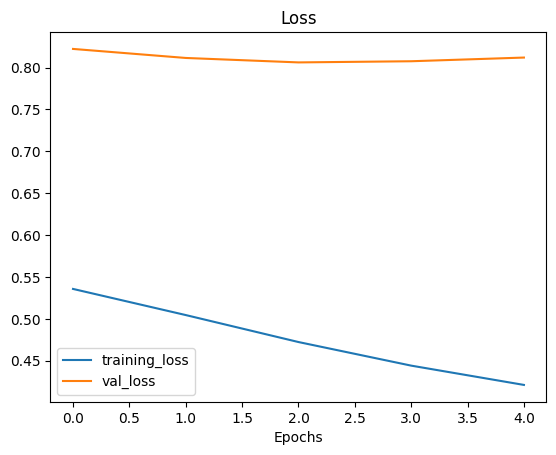

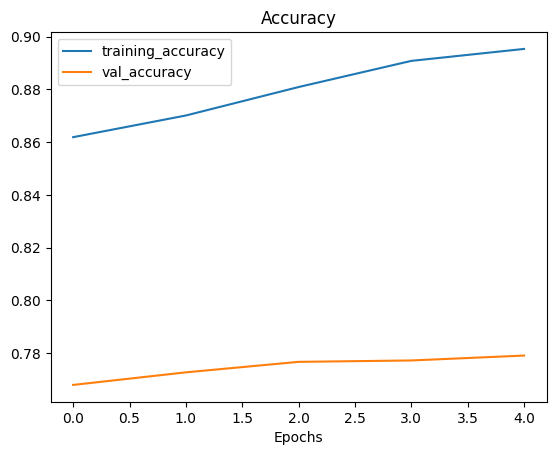

In [46]:
hf.plot_loss_curves(history_101_fine_tune_final)

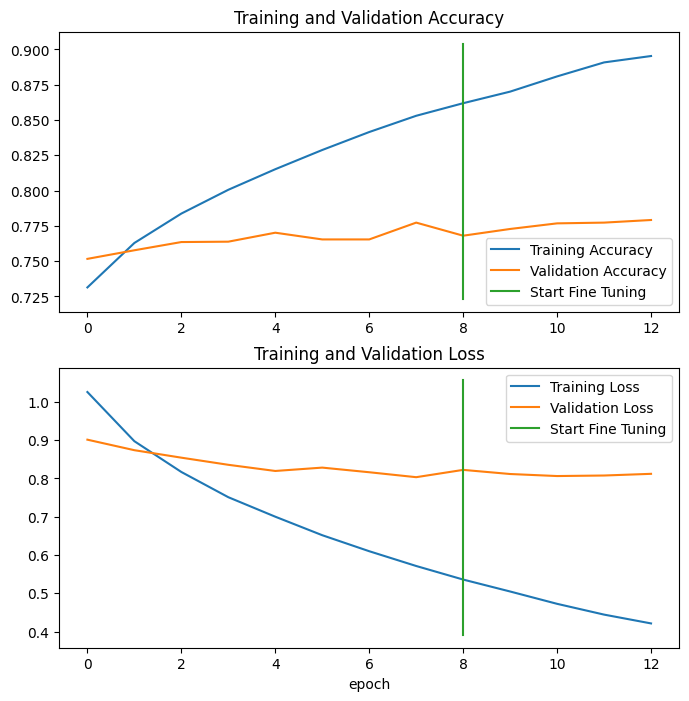

In [47]:
hf.compare_histories(history_101_food_classes_fine_tune, history_101_fine_tune_final, history_101_food_classes_fine_tune.epoch[-1])